In [1]:
# Import necessary modules
import nest_asyncio
from ib_insync import IB, Stock, util

# Apply `nest_asyncio` to avoid event loop issues in Jupyter notebooks
nest_asyncio.apply()

# Initialize IB instance
ib = IB()

# Define a callback for error handling
def onError(reqId, errorCode, errorString, advancedOrderRejectInfo=None):
    print(f"[Error] Request ID: {reqId}, Error Code: {errorCode}, Message: {errorString}")
    
# Define a callback for tracking order status
def onOrderStatus(order):
    print(f"[Order Status] Order {order.orderId} is {order.status}")

# Register callbacks to IB instance
ib.errorEvent += onError
ib.orderStatusEvent += onOrderStatus

# Attempt to connect to TWS
try:
    ib.connect('127.0.0.1', 7497, clientId=2)
    print("[Success] Successfully connected to TWS!")
except Exception as e:
    print(f"[Error] Failed to connect to TWS: {str(e)}")

[Error] Request ID: -1, Error Code: 2104, Message: Market data farm connection is OK:usfarm.nj
[Error] Request ID: -1, Error Code: 2104, Message: Market data farm connection is OK:usfuture
[Error] Request ID: -1, Error Code: 2104, Message: Market data farm connection is OK:cashfarm
[Error] Request ID: -1, Error Code: 2104, Message: Market data farm connection is OK:usopt
[Error] Request ID: -1, Error Code: 2104, Message: Market data farm connection is OK:usfarm
[Error] Request ID: -1, Error Code: 2106, Message: HMDS data farm connection is OK:ushmds
[Error] Request ID: -1, Error Code: 2158, Message: Sec-def data farm connection is OK:secdefnj
[Success] Successfully connected to TWS!


Value (Trade(contract=Stock(symbol='SPY', exchange='SMART', currency='USD'), order=MarketOrder(orderId=7, clientId=2, permId=600843352, action='BUY', totalQuantity=1.0, lmtPrice=629.3, auxPrice=0.0), orderStatus=OrderStatus(orderId=7, status='PreSubmitted', filled=0.0, remaining=1.0, avgFillPrice=0.0, permId=600843352, parentId=0, lastFillPrice=0.0, clientId=2, whyHeld='', mktCapPrice=0.0), fills=[], log=[TradeLogEntry(time=datetime.datetime(2025, 7, 22, 19, 3, 32, 586166, tzinfo=datetime.timezone.utc), status='PendingSubmit', message='', errorCode=0), TradeLogEntry(time=datetime.datetime(2025, 7, 22, 19, 3, 33, 130906, tzinfo=datetime.timezone.utc), status='PreSubmitted', message='', errorCode=0)], advancedError=''),) caused exception for event Event<orderStatusEvent, [[None, None, <function onOrderStatus at 0x130c75080>]]>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/eventkit/event.py", line 202, in emit
    result = func(*args)
  File "/var/

[Error] Request ID: 11, Error Code: 2174, Message: Warning: You submitted request with date-time attributes without explicit time zone. Please switch to use yyyymmdd-hh:mm:ss in UTC or use instrument time zone, like US/Eastern. Implied time zone functionality will be removed in the next API release


In [2]:
# Verify connection by requesting the server time

try:
    # Request server time
    server_time = ib.reqCurrentTime()
    print(f"[Success] Current server time: {server_time}")
except Exception as e:
    print(f"[Error] Failed to retrieve server time: {str(e)}")

[Success] Current server time: 2025-07-22 19:03:32+00:00


In [3]:
# Create the stock contract for SPY
spy_contract = Stock('SPY', 'SMART', 'USD')

# Define a market order for 1 share (use the global MarketOrder function)
from ib_insync import MarketOrder
spy_market_order = MarketOrder('BUY', 1)

# Place the order and store the returned trade object
print("[Info] Placing the market order for 1 share of SPY...")
trade = ib.placeOrder(spy_contract, spy_market_order)

# Wait until the order is processed (either filled, rejected, etc.)
print("[Info] Waiting for the order to be processed...")
while not trade.isDone():
    ib.waitOnUpdate()

# Check the order status
order_status = trade.orderStatus.status
print(f"[Order Status] The order status is: {order_status}")

# Verify the open orders list
open_orders = ib.openOrders()
if trade.order in open_orders:
    print("[Check] Order is still in the open orders list.")
else:
    print("[Check] Order is no longer in the open orders list (likely filled or canceled).")

# Verify the portfolio for SPY position
portfolio = ib.portfolio()
spy_position = next((p for p in portfolio if p.contract.symbol == 'SPY'), None)
if spy_position:
    print(f"[Success] Portfolio updated. Current SPY position: {spy_position.position} shares")
else:
    print("[Check] SPY position not found in portfolio (order may not be filled yet).")


[Info] Placing the market order for 1 share of SPY...
[Info] Waiting for the order to be processed...
[Order Status] The order status is: Filled
[Check] Order is no longer in the open orders list (likely filled or canceled).
[Success] Portfolio updated. Current SPY position: 1.0 shares


In [4]:
# Create a market order to sell 1 share of SPY
spy_sell_order = MarketOrder('SELL', 1)

# Place the sell order using the existing SPY contract
print("[Info] Placing the market order to sell 1 share of SPY...")
sell_trade = ib.placeOrder(spy_contract, spy_sell_order)

# Wait until the sell order is processed
print("[Info] Waiting for the sell order to be processed...")
while not sell_trade.isDone():
    ib.waitOnUpdate()

# Check the sell order status
sell_order_status = sell_trade.orderStatus.status
print(f"[Order Status] The sell order status is: {sell_order_status}")

# Verify the open orders list after the sell order
sell_open_orders = ib.openOrders()
if sell_trade.order in sell_open_orders:
    print("[Check] Sell order is still in the open orders list.")
else:
    print("[Check] Sell order is no longer in the open orders list (likely filled or canceled).")

# Verify the portfolio position for SPY after the sell
portfolio_after_sell = ib.portfolio()
spy_position_after_sell = next((p for p in portfolio_after_sell if p.contract.symbol == 'SPY'), None)
if spy_position_after_sell:
    print(f"[Check] SPY position is still present in portfolio. Current position: {spy_position_after_sell.position} shares.")
else:
    print("[Success] SPY position has been closed in the portfolio.")


[Info] Placing the market order to sell 1 share of SPY...
[Info] Waiting for the sell order to be processed...
[Order Status] The sell order status is: Filled
[Check] Sell order is no longer in the open orders list (likely filled or canceled).
[Check] SPY position is still present in portfolio. Current position: 1.0 shares.


In [5]:

import pandas as pd

# Ensure the connection to IB is active
if not ib.isConnected():
    print("[Error] Not connected to TWS. Please reconnect before requesting data.")
else:
    try:
        # Request 300 days of daily price data for SPY
        print("[Info] Requesting historical price data for SPY...")
        historical_data = ib.reqHistoricalData(
            spy_contract,
            endDateTime='',
            durationStr='300 D',
            barSizeSetting='1 day',
            whatToShow='TRADES',
            useRTH=True
        )
        
        # Convert to a Pandas DataFrame
        df = util.df(historical_data)
        
        if not df.empty:
            print("[Success] Historical price data retrieved successfully.")
            # Display the first few rows of the DataFrame
            print(df.head())
        else:
            print("[Error] No historical data returned for SPY.")
    except Exception as e:
        print(f"[Error] An error occurred while requesting historical data: {str(e)}")


[Info] Requesting historical price data for SPY...
[Success] Historical price data retrieved successfully.
         date    open    high     low   close      volume  average  barCount
0  2024-05-09  517.38  520.21  516.70  520.17  31989097.0  519.061    180834
1  2024-05-10  521.81  522.64  519.59  520.84  33998102.0  520.938    187478
2  2024-05-13  522.56  522.67  519.74  520.91  25940155.0  521.074    151902
3  2024-05-14  521.10  523.83  520.56  523.30  34867860.0  522.324    194652
4  2024-05-15  525.83  530.08  525.18  529.78  40247931.0  528.120    228206


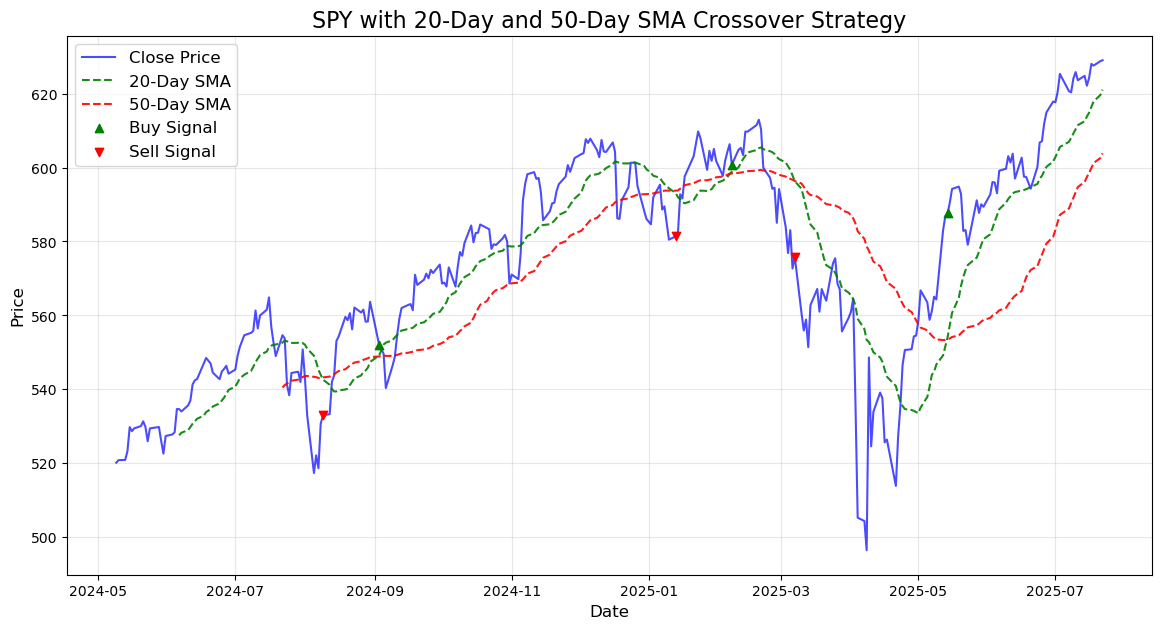

In [6]:
# Calculate 20-day and 50-day simple moving averages
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()

# Identify Buy/Sell signals
df['Signal'] = 0  # Initialize signal column with 0
df.loc[df['SMA_20'] > df['SMA_50'], 'Signal'] = 1  # Buy signal
df.loc[df['SMA_20'] < df['SMA_50'], 'Signal'] = -1  # Sell signal

# Detect Buy/Sell crossover points
df['Buy_Signal'] = (df['Signal'] == 1) & (df['Signal'].shift(1) == -1)
df['Sell_Signal'] = (df['Signal'] == -1) & (df['Signal'].shift(1) == 1)

# Import Matplotlib for visualization
import matplotlib.pyplot as plt

# Plot price history and moving averages
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['close'], label='Close Price', color='blue', alpha=0.7)
plt.plot(df['date'], df['SMA_20'], label='20-Day SMA', color='green', linestyle='--', alpha=0.9)
plt.plot(df['date'], df['SMA_50'], label='50-Day SMA', color='red', linestyle='--', alpha=0.9)

# Plot buy signals
plt.scatter(
    df['date'][df['Buy_Signal']], 
    df['close'][df['Buy_Signal']],
    label='Buy Signal',
    marker='^',
    color='green',
    alpha=1,
    zorder=5
)

# Plot sell signals
plt.scatter(
    df['date'][df['Sell_Signal']], 
    df['close'][df['Sell_Signal']],
    label='Sell Signal',
    marker='v',
    color='red',
    alpha=1,
    zorder=5
)

# Add chart labels and legend
plt.title('SPY with 20-Day and 50-Day SMA Crossover Strategy', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [7]:
import time
import logging
from threading import Thread, Event

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Flag to stop the monitoring thread
stop_event = Event()

# Define the live monitoring function
def monitor_and_trade(interval=3600):  # Default interval: 1 hour
    logging.info("Monitoring system started.")
    
    while not stop_event.is_set():
        try:
            # Ensure IB connection is active
            if not ib.isConnected():
                logging.error("Lost connection to IB. Attempting to reconnect...")
                ib.connect('serveo.net', 7497, clientId=1)

            # Fetch latest portfolio positions
            portfolio = ib.portfolio()
            current_spy_position = next((p.position for p in portfolio if p.contract.symbol == 'SPY'), 0)

            # Get the latest data point
            latest_data = df.iloc[-1]
            
            # Determine buy/sell actions based on the strategy
            if latest_data['Buy_Signal'] and current_spy_position <= 0:  # Buy signal
                logging.info("Buy signal triggered. Placing a buy order for SPY...")
                ib.placeOrder(Stock('SPY', 'SMART', 'USD'), MarketOrder('BUY', 1))
            
            elif latest_data['Sell_Signal'] and current_spy_position > 0:  # Sell signal
                logging.info("Sell signal triggered. Placing a sell order for SPY...")
                ib.placeOrder(Stock('SPY', 'SMART', 'USD'), MarketOrder('SELL', 1))

            else:
                logging.info("No action required. Monitoring continues...")

        except Exception as e:
            logging.error(f"An error occurred: {str(e)}")

        # Wait for the specified interval before the next cycle
        time.sleep(interval)
    
    logging.info("Monitoring system stopped.")

# Start the monitoring system in a background thread
monitor_thread = Thread(target=monitor_and_trade, kwargs={'interval': 3600}, daemon=True)  # Default to 1-hour checks
monitor_thread.start()
print("Monitoring system is running. Use the stop_event.set() command to stop it safely.")

# Stopping the monitoring system
stop_event.set()
monitor_thread.join()
print("Monitoring system has been stopped.")


2025-07-22 12:03:34,795 - Monitoring system started.
2025-07-22 12:03:34,797 - Monitoring system stopped.


Monitoring system is running. Use the stop_event.set() command to stop it safely.
Monitoring system has been stopped.


In [ ]:
import nest_asyncio
nest_asyncio.apply()

from ib_insync import IB, Stock, MarketOrder, util

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=2)  # Safe to run in Jupyter now

spy_contract = Stock('SPY', 'SMART', 'USD')

# Define trade logic
def trade_bot():
    print("[Info] Running bot... Fetching data...")

    try:
        bars = ib.reqHistoricalData(
            spy_contract,
            endDateTime='',
            durationStr='1 D',
            barSizeSetting='5 mins',
            whatToShow='TRADES',
            useRTH=True,
            formatDate=1
        )
        df = util.df(bars)

        df['SMA20'] = df['close'].rolling(window=20).mean()
        df['SMA50'] = df['close'].rolling(window=50).mean()
        latest = df.iloc[-1]

        print(f"[Data] Last Close: {latest['close']:.2f}, SMA20: {latest['SMA20']:.2f}, SMA50: {latest['SMA50']:.2f}")

        # Check current position
        position = next((p.position for p in ib.positions() if p.contract.symbol == 'SPY'), 0)

        if latest['SMA20'] > latest['SMA50'] and position == 0:
            print("📈 Signal: BUY")
            ib.placeOrder(spy_contract, MarketOrder('BUY', 1))

        elif latest['SMA20'] < latest['SMA50'] and position > 0:
            print("📉 Signal: SELL")
            ib.placeOrder(spy_contract, MarketOrder('SELL', 1))

        else:
            print("⚠️ No trade signal or already in position.")

    except Exception as e:
        print(f"[Error] {str(e)}")

# Schedule the job every 15 minutes
schedule.every(15).minutes.do(trade_bot)

# Run once right now to test
trade_bot()

# Keep running every 15 min
while True:
    schedule.run_pending()
    time.sleep(1)


[Info] Running bot... Fetching data...
[Data] Last Close: 629.30, SMA20: 628.79, SMA50: 628.19
⚠️ No trade signal or already in position.
[Info] Running bot... Fetching data...
[Data] Last Close: 629.08, SMA20: 628.81, SMA50: 628.27
⚠️ No trade signal or already in position.


Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IBKR and Trader Workstation has been restored - data maintained. All data farms are connected: usfarm.nj; usfuture; cashfarm; usopt; usfarm; ushmds; secdefnj.


[Info] Running bot... Fetching data...
[Data] Last Close: 629.20, SMA20: 628.92, SMA50: 628.35
⚠️ No trade signal or already in position.
